In [48]:
import matplotlib.pyplot as plt
import numpy as np
import time
#from lwautils import lwa_arx 
import pandas as pd
from cr_data_inspection_functions import *
import struct
import math
from lwa_antpos import mapping
import os
from lwa_antpos import reading


##load arraymap
array_map=pd.read_csv('array-map-5-22-2023.csv')
xdict={}
ydict={}
zdict={}
for i,n in enumerate(array_map['antname']):
    xdict[n]=array_map['x'][i]
    ydict[n]=array_map['y'][i]
    zdict[n]=array_map['elevation'][i]
arraymapdictionaries=[xdict,ydict,zdict]

lwa_df = reading.read_antpos()
namedict=build_mapping_dictionary(lwa_df)

In [49]:
# for s in range(1,12):
#        for i  in range(0,64):
#            print(s,i,lookup_antname(lwa_df,s,i))

In [50]:
#24th order
h= np.asarray([0.000049291111379545783611425685544205066,
               0.012255497574972781804625299173494568095,
               0.085289616177628382875930412865272955969,
               -0.063136263203890236050952466939634177834,
               -0.021489412960359111082198069198057055473,
               -0.067555957743183181474222465112688951194,
               -0.017706118779731286339007567676162580028,
               0.080882151494431037130894424080906901509,
               -0.014358148251631907416081546102759602945,
               0.093835202832724035060252276707615237683,
               -0.280577771800571862392814637132687494159,
               -0.129748808680352711864003367736586369574,
               0.501393724111570460166831253445707261562,
               -0.129748808680352711864003367736586369574,
               -0.280577771800571862392814637132687494159,
               0.093835202832724035060252276707615237683,
               -0.014358148251631907416081546102759602945,
               0.080882151494431037130894424080906901509,
               -0.017706118779731286339007567676162580028,
               -0.067555957743183181474222465112688951194,
               -0.021489412960359111082198069198057055473,
               -0.063136263203890236050952466939634177834,
               0.085289616177628382875930412865272955969,
               0.012255497574972781804625299173494568095,
               0.000049291111379545783611425685544205066])

## Check snapshot

In [76]:
#fname='/data0/cosmic-ray-data/2023June30/test1688168925.1072624.dat' #file with a single snapshot
#fname='/home/ubuntu/kp/data/2023July3-overnight-software-trigger/test1688443082.2519193.dat'
#fname='/home/ubuntu/kp/data/2023July3-overnight-software-trigger/test21688445108.6517596.dat'
#fname='/data0/cosmic-ray-data/2023July4/test1688527143.5566494.dat'
#fname='/data0/cosmic-ray-data/2023August9/test1691641850.5293252.dat' #old ARX settings
#fname='/data0/cosmic-ray-data/2023August9/test1691643774.8350217.dat' #latest ARX settings
#fname='/data0/cosmic-ray-data/2024February20/test1708492386.2733262.dat'
#fname = '/data0/cosmic-ray-data/2024February21/test1708569562.3720453.dat'
#fname = '/data0/cosmic-ray-data/2024February27/old-veto-assignments/test1709095643.8127391.dat'
fname = '/data0/cosmic-ray-data/2024April26/test1714189270.4888074.dat'

records=parsefile(fname)
mergedrecords=mergepolarizations(records,arraymapdictionaries,namedict,Filter=h)

antennas=np.asarray([int(record['antname'][4:]) for record in mergedrecords])
order_by_antname=sorted(zip(antennas,mergedrecords))
records_by_antname=[pair[1] for pair in order_by_antname]
sorted_antennas=[pair[0] for pair in order_by_antname]

#get rms before event -- this is actually the standard deviation
rmsA=np.asarray([record['rmsA'] for record in records_by_antname])
rmsB=np.asarray([record['rmsB'] for record in records_by_antname])

#get mean power before event
meansmoothedA=np.asarray([record['meansmoothedA'] for record in records_by_antname])
meansmoothedB=np.asarray([record['meansmoothedB'] for record in records_by_antname])

    
#get kurtosis 
kurtosisA=np.asarray([record['kurtosisA'] for record in records_by_antname])
kurtosisB=np.asarray([record['kurtosisB'] for record in records_by_antname])


absmaxA=np.asarray([np.max(np.abs(record['polA_data'])) for record in records_by_antname])
absmaxB=np.asarray([np.max(np.abs(record['polB_data'])) for record in records_by_antname])                    

/home/ubuntu/kp/lwa-cosmic-rays/cr_data_inspection_functions.py:439: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if Filter!='None':
/home/ubuntu/kp/lwa-cosmic-rays/cr_data_inspection_functions.py:459: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if Filter!='None':
/home/ubuntu/anaconda3/envs/deployment/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/deployment/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


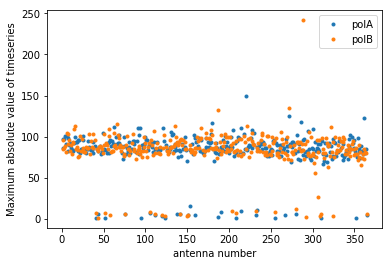

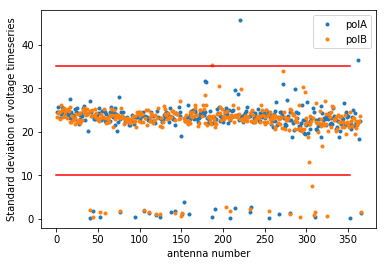

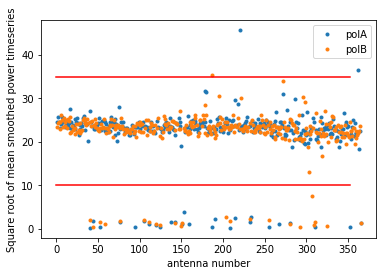

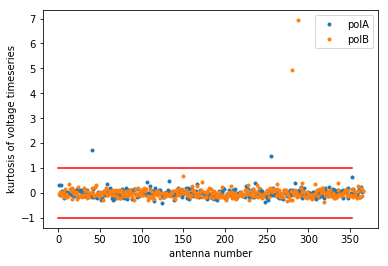

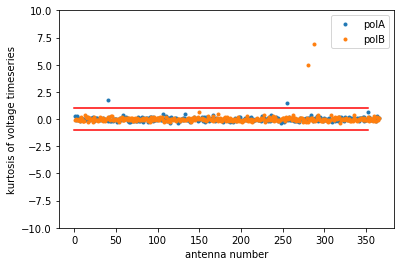

In [77]:
plt.figure()
plt.plot(sorted_antennas,absmaxA,'.',label='polA')
plt.plot(sorted_antennas,absmaxB,'.',label='polB')
plt.xlabel('antenna number')
plt.ylabel('Maximum absolute value of timeseries')
plt.legend()

plt.figure()
plt.plot(sorted_antennas,rmsA,'.',label='polA')
plt.plot(sorted_antennas,rmsB,'.',label='polB')
plt.ylabel('Standard deviation of voltage timeseries')
plt.xlabel('antenna number')
plt.plot([0,352],[10,10],'r')
plt.plot([0,352],[35,35],'r')
plt.legend()

plt.figure()
plt.plot(sorted_antennas,np.sqrt(meansmoothedA),'.',label='polA')
plt.plot(sorted_antennas,np.sqrt(meansmoothedB),'.',label='polB')
plt.ylabel('Square root of mean smoothed power timeseries')
plt.xlabel('antenna number')
plt.plot([0,352],[10,10],'r')
plt.plot([0,352],[35,35],'r')
plt.legend()

plt.figure()
plt.plot(sorted_antennas,kurtosisA,'.',label='polA')
plt.plot(sorted_antennas,kurtosisB,'.',label='polB')
plt.ylabel('kurtosis of voltage timeseries')
plt.xlabel('antenna number')
plt.plot([0,352],[-1,-1],'r')
plt.plot([0,352],[1,1],'r')
plt.legend()

plt.figure()
plt.plot(sorted_antennas,kurtosisA,'.',label='polA')
plt.plot(sorted_antennas,kurtosisB,'.',label='polB')
plt.ylabel('kurtosis of voltage timeseries')
plt.xlabel('antenna number')
plt.plot([0,352],[-1,-1],'r')
plt.plot([0,352],[1,1],'r')
plt.ylim(-10,10)
#plt.ylim(-1,100)
plt.legend()


In [78]:
#plot_spectra(records,['LWA-042A','LWA-105B','LWA-150A'],zoom='peak',Filter='None')


In [79]:
#plot_spectra(records,['LWA-042A','LWA-105B','LWA-150A'],zoom='peak',Filter=h)


In [80]:
#for r in mergedrecords:
#    if r['kurtosisA']>90:
#        print(r['antname'],r['kurtosisA'],r['kurtosisB'])


In [81]:

#plt.figure()
#plt.plot(sorted_antennas,absmaxA,'.',label='polA')
#plt.plot(sorted_antennas,absmaxB,'.',label='polB')
#plt.xlabel('antenna number')
#plt.ylabel('Maximum absolute value of timeseries')
#plt.legend()
#plt.xlim((285,290))

In [82]:
#plot_timeseries(records,['LWA-280A','LWA-280B','LWA-288A','LWA-288B'])

## Define Veto Antennas

In [83]:


brdnames=['snap01','snap02','snap03','snap04','snap05','snap06','snap07','snap08','snap09','snap10','snap11']

#first, make arrays holding the veto and core antenna assignments, whether or not that antenna is online
veto_antennas_names={}
veto_antennas_names['snap08']=['LWA-322','LWA-326','LWA-333','LWA-347']
veto_antennas_names['snap05']=['LWA-328','LWA-325','LWA-334','LWA-316']
veto_antennas_names['snap10']=['LWA-297','LWA-350','LWA-356','LWA-342']
veto_antennas_names['snap11']=['LWA-264','LWA-261','LWA-315','LWA-300']
veto_antennas_names['snap04']=['LWA-331','LWA-348','LWA-364']
veto_antennas_names['snap09']=['LWA-349','LWA-329','LWA-290','LWA-357']
veto_antennas_names['snap07']=['LWA-287','LWA-279','LWA-355']
veto_antennas_names['snap06']=['LWA-319','LWA-299','LWA-289']
veto_antennas_names['snap03']=['LWA-275','LWA-286','LWA-302','LWA-363']
veto_antennas_names['snap01']=['LWA-353', 'LWA-362', 'LWA-341']
veto_antennas_names['snap02']=['LWA-354','LWA-298','LWA-360'] 


veto_roles=np.zeros((11,64),dtype=int)  #array to identify the antennas to be assigned as vetos
core_roles=np.ones((11,64),dtype=int)  #array to identify the antennas to be assigned as core antennas
for i in range(11):
    snap=brdnames[i]
    vetonames=veto_antennas_names[snap]
    for ant in vetonames:
        brd,inputnumberA=mapping.antpol_to_fpga(ant,'A')
        brd,inputnumberB=mapping.antpol_to_fpga(ant,'B')
        veto_roles[i,inputnumberA]=1 #set the veto role to 1 for inputs corresponding to veto antennas
        veto_roles[i,inputnumberB]=1
        core_roles[i,inputnumberA]=0 #set the core role to zero for veto antennas
        core_roles[i,inputnumberB]=0
        
        

##  now figure out which antennas are ok


In [84]:
#now figure out which antennas are ok
antenna_status_array=np.zeros((11,64),dtype=int)  #array whose elements are 1 if the antenna has an ok rms&kurtosis and 0 otherwise

minimum_acceptable_rms=15
maximum_acceptable_rms=35
minimum_acceptable_kurtosis=-10
maximum_acceptable_kurtosis=10
for r in mergedrecords:
    snap=r['board_id']
    brd_index=snap-1
    antenna_id_A=packet_ant_id_2_snap_input(r['antenna_id_A'])
    antenna_id_B=packet_ant_id_2_snap_input(r['antenna_id_B'])
    rmsA=r['rmsA']
    rmsB=r['rmsB']
    kurtosisA=r['kurtosisA']
    kurtosisB=r['kurtosisB']
    
    
    # if both polarizations pass both criteria, then use them, otherwise neither is ok
    if ((minimum_acceptable_kurtosis < kurtosisA < maximum_acceptable_kurtosis) and (minimum_acceptable_kurtosis < kurtosisB < maximum_acceptable_kurtosis) and (minimum_acceptable_rms < rmsA < maximum_acceptable_rms) and minimum_acceptable_rms < rmsB < maximum_acceptable_rms):
        antenna_status_array[brd_index,antenna_id_A]=1
        antenna_status_array[brd_index,antenna_id_B]=1

## Combine antenna status with core and veto roles

In [85]:
#calculate arrays of good veto antennas and good core antennas, and check which subarrays have enough
ok_vetos=np.multiply(antenna_status_array,veto_roles)
ok_core=np.multiply(antenna_status_array,core_roles)

for b in range(11):
    print('snap',b+1, np.sum(ok_vetos[b]),np.sum(ok_core[b]))
    
np.save('/home/ubuntu/kp/ok_vetos-2024-4-26',ok_vetos)
np.save('/home/ubuntu/kp/ok_core-2024-4-26',ok_core)

snap 1 4 48
snap 2 6 50
snap 3 8 52
snap 4 6 54
snap 5 6 52
snap 6 6 56
snap 7 6 46
snap 8 8 46
snap 9 8 54
snap 10 8 48
snap 11 8 52


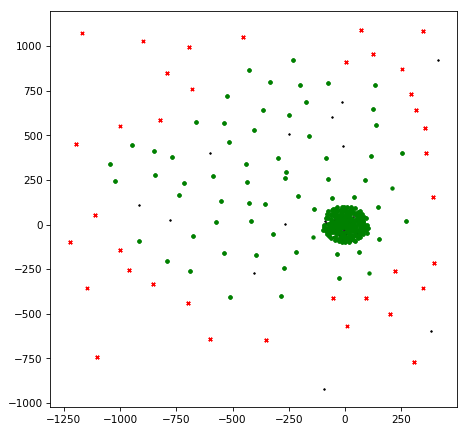

In [86]:
allants=[]
corelist=[]
vetolist=[]
for b in range(11):
    for a in range(63):
        allants.append(lookup_antname_in_dictionary(namedict,b+1,a))
        if ok_vetos[b,a]:
            vetolist.append(lookup_antname_in_dictionary(namedict,b+1,a))
        if ok_core[b,a]:
                corelist.append(lookup_antname_in_dictionary(namedict,b+1,a))

x_all=[xdict[name[:-1]] for name in allants]
y_all=[ydict[name[:-1]] for name in allants]
xcorelist=[xdict[name[:-1]] for name in corelist]
ycorelist=[ydict[name[:-1]] for name in corelist]
xvetolist=[xdict[name[:-1]] for name in vetolist]
yvetolist=[ydict[name[:-1]] for name in vetolist]

plt.figure(figsize=(7,7),dpi=75)
plt.scatter(x_all,y_all,marker='o',color='k',label='all antennas',s=1)
plt.scatter(xcorelist,ycorelist,marker='o',color='green',label='core antennas',s=10)
plt.scatter(xvetolist,yvetolist,marker='x',color='red',label='core antennas',s=10)

#uncomment to label antennas
#for name in allants:
#    plt.text(xdict[name[:-1]],ydict[name[:-1]],name)


# Check settings
I sent new snapshots after applying the settings.

In [160]:
#records_all_good_vetos=parsefile('/data0/cosmic-ray-data/2024February27/test-vetos-all1709099257.2188728.dat')
#records_A_vetos=parsefile('/data0/cosmic-ray-data/2024February27/test-vetos-A1709099330.6583197.dat')
#records_B_vetos=parsefile('/data0/cosmic-ray-data/2024February27/test-vetos-B1709099395.820296.dat')


#allones=parsefile('/data0/cosmic-ray-data/2024February28/test-ones1709163881.6531832.dat')
#allzeros=parsefile('/data0/cosmic-ray-data/2024February28/test-zeros1709164398.597236.dat')

In [87]:
'''
for event_records in [allzeros]:

    for record in event_records:
            record['antname']=lookup_antname_in_dictionary(namedict,record['board_id'],packet_ant_id_2_snap_input(record['antenna_id']))
    event_records[0].keys()

    used=[]
    for r in event_records:
        if r['veto_role']:
            #print(r['antname'])
            used.append(r['antname'])

    allant=[r['antname'][:-1] for r in event_records]
    x_all=[xdict[name] for name in allant]
    y_all=[ydict[name] for name in allant]

    usedA=[]
    usedB=[]
    for n in used:
        if n[-1]=='A':
            usedA.append(n[:-1])
        if n[-1]=='B':
            usedB.append(n[:-1])

    intended=['LWA-322','LWA-326','LWA-333','LWA-347',
              'LWA-328','LWA-325','LWA-334','LWA-316',
              'LWA-297','LWA-350','LWA-356','LWA-342',
              'LWA-264','LWA-261','LWA-315','LWA-300',
              'LWA-331','LWA-348','LWA-364',
              'LWA-349','LWA-329','LWA-290','LWA-357',
              'LWA-287','LWA-279','LWA-355',
              'LWA-319','LWA-299','LWA-289',
              'LWA-275','LWA-286','LWA-302','LWA-363']

    x_intended=[xdict[name] for name in intended]
    y_intended=[ydict[name] for name in intended]
    x_usedA=[xdict[name] for name in usedA]
    x_usedB=[xdict[name] for name in usedB]
    y_usedA=[ydict[name] for name in usedA]
    y_usedB=[ydict[name] for name in usedB]

    plt.figure(figsize=(7,7),dpi=75)

    plt.scatter(x_all,y_all,marker=',',color='k',label='all antennas',s=1)
    plt.scatter(x_intended,y_intended,alpha=0.5,label='intended')
    plt.scatter(x_usedA,y_usedA,marker='*',label='used A pol',color='orange')
    plt.scatter(x_usedB,y_usedB,marker='*',label='used B pol',color='orange')
    plt.legend()

    plt.figure(figsize=(6,6))
    plt.scatter(x_all,y_all,marker=',',color='k',label='all antennas',s=1)
    plt.scatter(x_usedA,y_usedA,marker='o',label='used A pol')
    plt.scatter(x_usedB,y_usedB,marker='*',label='used B pol')
    plt.legend()'''

"\nfor event_records in [allzeros]:\n\n    for record in event_records:\n            record['antname']=lookup_antname_in_dictionary(namedict,record['board_id'],packet_ant_id_2_snap_input(record['antenna_id']))\n    event_records[0].keys()\n\n    used=[]\n    for r in event_records:\n        if r['veto_role']:\n            #print(r['antname'])\n            used.append(r['antname'])\n\n    allant=[r['antname'][:-1] for r in event_records]\n    x_all=[xdict[name] for name in allant]\n    y_all=[ydict[name] for name in allant]\n\n    usedA=[]\n    usedB=[]\n    for n in used:\n        if n[-1]=='A':\n            usedA.append(n[:-1])\n        if n[-1]=='B':\n            usedB.append(n[:-1])\n\n    intended=['LWA-322','LWA-326','LWA-333','LWA-347',\n              'LWA-328','LWA-325','LWA-334','LWA-316',\n              'LWA-297','LWA-350','LWA-356','LWA-342',\n              'LWA-264','LWA-261','LWA-315','LWA-300',\n              'LWA-331','LWA-348','LWA-364',\n              'LWA-349','LWA-329